# Library

In [87]:
import pandas as pd
import nltk
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json
import re
import emoji
import numpy as np

from nltk.corpus import stopwords

from nlp_id.lemmatizer import Lemmatizer
from bahasa.stemmer import Stemmer 

nltk.download('stopwords')
stop_words = set('indonesian')  # Tentukan bahasa



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rowjak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load & Understand Dataset

In [88]:
project_path = os.getcwd()
dataset_path = "dataset"
dictionary_path = "dictionary"
dataset_name = "tweet.csv"

df = pd.read_csv(os.path.join(project_path,dataset_path,dataset_name),encoding='UTF-8')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1815 non-null   int64 
 1   sentimen    1815 non-null   object
 2   tweet       1815 non-null   object
dtypes: int64(1), object(2)
memory usage: 42.7+ KB


In [89]:
# Menghapus kolom unnamed : 
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,sentimen,tweet
0,negatif,Kata @prabowo Indonesia tidak dihargai bangsa ...
1,netral,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib..."
2,netral,"Di era Jokowi, ekonomi Indonesia semakin baik...."
3,positif,"Bagi Sumatera Selatan, Asian Games berdampak p..."
4,negatif,Negara kita ngutang buat bngun infrastruktur y...


In [90]:
# cek apakah terdapat kolom null
df.isna().sum()/len(df)

sentimen    0.0
tweet       0.0
dtype: float64

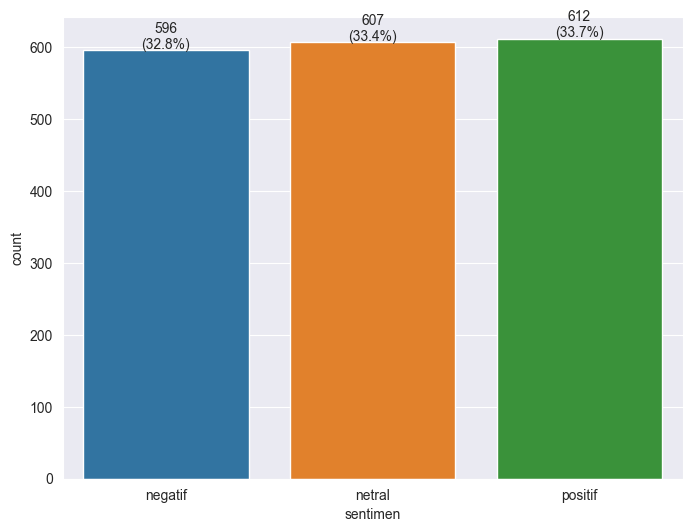

In [91]:
# cek jumlah data pada tiap-tiap label.
plt.figure(figsize=(8, 6), dpi=100)
ax = sns.countplot(data=df, x='sentimen', hue='sentimen')
total = float(len(df))

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}\n({height/total:.1%})', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 10), textcoords='offset points')

plt.show()

label sentimen yang ada cukup balance, sehingga tidak memerlukan oversampling maupun undersampling.

In [92]:
# cek duplikasi data
print('Jumlah Data : ',len(df))

df = df.drop_duplicates()
print('Jumlah Data setelah menghapus data duplikat :', len(df))

Jumlah Data :  1815
Jumlah Data setelah menghapus data duplikat : 1815


## Text Preprocessing

*   Merubah tweet menjadi huruf kecil
*   Merubah emoji menjadi kata yang bermakna
*   Menghapus tanda baca
*   Menghapus karakter khusus
*   Menghapus Hashtag(#), username , @, dan url
*   Menghapus stopwords
*   Menghapus spasi berlebih
*   Merubah slangwords ke kata asli







In [93]:
# Merubah tweet menjadi huruf kecil
df['tweet_lower'] = df['tweet'].str.lower()

# Merubah emoji menjadi kata yang bermakna



# Menghapus hashtag dan username dari kolom tweet
df['tweet_no_user_hashtag'] = df['tweet_lower'].str.replace(r'@\w+|#\w+', '', regex=True)

# Menghapus URL dari kolom tweet
df['tweet_no_url'] = df['tweet_no_user_hashtag'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
df['tweet_no_url'] = df['tweet_no_url'].str.replace(r'pic\.twitter\.com/\S+', '', regex=True)

# Memastikan kolom tweet berisi string sebelum melakukan penghapusan tanda baca dan special character
df['tweet_sc'] = df['tweet_no_url'].astype(str).str.replace(r'[^\w\s]', ' ', regex=True)

# Menghapus Stopswords
exc_stopwords = [
    'tidak', 'belum', 'bukan', 'tanpa', 'jarang', 'kurang',
    'baik', 'bisa', 'mungkin', 'boleh', 'masalah'
]
stop_words = set(stopwords.words('indonesian'))
# Gabungkan stop words dengan exclude stop words
stop_words = stop_words - set(exc_stopwords)

df['tweet_no_sw'] = df['tweet_sc'].str.split().apply(
    lambda x: ' '.join([word for word in x if word not in stop_words])
)

# Menghapus spasi di awal dan akhir, dan mengganti spasi ganda dengan satu spasi
df['tweet_no_extra_space'] = df['tweet_no_sw'].str.strip().str.replace(r'\s+', ' ', regex=True)


# Merubah slangwords ke kata asli
# explore slangwords : https://github.com/louisowen6/NLP_bahasa_resources
with open(os.path.join(project_path,dictionary_path,'combined_slang_words.json'), 'r') as json_file:
    slang_words_dict = json.load(json_file)

def process_slang(text, dictionary=slang_words_dict):
    slang_words = re.compile(r'\b(?:' + '|'.join(re.escape(word) for word in dictionary.keys()) + r')\b')
    output = slang_words.sub(lambda x: dictionary[x.group()], text)
    return output
    
df['tweet_no_slang'] = df['tweet_no_extra_space'].apply(process_slang)

df['tweet_test'] = df['tweet_no_slang']

In [94]:
df[['tweet','tweet_test']].head(15)

,tweet,tweet_test
0,Kata @prabowo Indonesia tidak dihargai bangsa ...,indonesia tidak dihargai bangsa asing berita ð...
1,"Batuan Langka, Tasbih Jokowi Hadiah dari Habib...",batuan langka tasbih jokowi hadiah habib luthf...
2,"Di era Jokowi, ekonomi Indonesia semakin baik....",era jokowi ekonomi indonesia baik
3,"Bagi Sumatera Selatan, Asian Games berdampak p...",sumatera selatan asian games berdampak pada ek...
4,Negara kita ngutang buat bngun infrastruktur y...,negara ngutang bngun infrastruktur sudah dipak...
5,"Yg bisikin pak jokowi, cm mikirin perputaran d...",yang bisikin jokowi cm mikirin perputaran duit...
6,Masa tenang msih ngoceh aja..ttp jokowi harga ...,tenang msih ngoceh saja ttp jokowi harga mati
7,#UASdifitnahKejiBalasDiTPS kerjasa ekonomi b...,kerjasa ekonomi bilateral multilateral doakan ...
8,"Iya bener Aa, kita MANTAP kan pilihan ke Pemim...",iya benar aa mantap pilihan pemimpin yang bisa...
9,Prabowo-Sandi Sepakat Tak Ambil Gaji karena Ne...,prabowo sandi sepakat ambil gaji negara susah â


## Text Normalization

In [95]:
stemmer = Stemmer()

# Fungsi untuk melakukan stemming
def stemming_tweet(tweet):
    return stemmer.stem(tweet)

# Menambahkan kolom 'tweet_stemming'
df['tweet_stemming'] = df['tweet_test'].apply(stemming_tweet)

In [96]:
# Fungsi untuk melakukan lemmatization
lemmatizer = Lemmatizer()

def lemmatize_indonesian_nlp_id(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())

# Terapkan lemmatization
df['tweet_lemmatized'] = df['tweet_test'].apply(lemmatize_indonesian_nlp_id)

In [97]:
# Ambil 10 baris secara acak
random_sample = df.sample(n=20, random_state=1)  # random_state untuk konsistensi hasil
for index, row in random_sample.iterrows():
    print(f"Index: {index}")
    print(f"Asli: {row['tweet']}")
    print(f"Stemming: {row['tweet_stemming']}")
    print(f"Lemmatized: {row['tweet_lemmatized']}")
    print("-" * 100)  # Pembatas antar tweet

Index: 596
Asli: Berita yang menyalahkan SBY sebagai salah satu pembuat kesalahan dalam perekonomian Indonesia, Mungkin sebaiknya hal tersebut tidak disebut Prabowo ke muka publik. Suatu kesalahan yang terlihat konyol.  http://cnn.id/386111Â 
Stemming: berita salah sby salah buat salah ekonomi indonesia mungkin tidak prabowo muka publik salah konyol
Lemmatized: berita salah sby salah buat salah ekonomi indonesia mungkin tidak prabowo muka publik salah konyol
----------------------------------------------------------------------------------------------------
Index: 972
Asli: Pak @jokowi menwarkan Program Membina Ekonomi Keluarga Sejahtera (Mekaar) binaan Permodalan Nasional Madani (PNM) diluncurkan untuk menaikkan kesejahteraan warga, terutama ibu-ibu rumah tangga ke tingkat yang lebih atas lagi.   https://setkab.go.id/presiden-jokowi-program-mekaar-untuk-naikkan-kesejahteraan-ibu-ibu/Â â€¦ #JokowiMenangTotalDebat
Stemming: menwarkan program bina ekonomi keluarga sejahtera mekaar bina m

## Hasil dari Text Preprocessing & Text Normalization

*   Semua data terjadi perubahan dari text preprocessing
*   Meskipun telah dicoba dengan Lematisasi dan Stemming, Tim Lebih memilih menggunakan lematisasi karena lebih akurat dalam mempertahankan makna

